In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization, LayerNormalization, Reshape, Permute, Bidirectional, Add, Attention, Flatten, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Layer, Concatenate
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score
import librosa
import soundfile as sf
import noisereduce as nr
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt

2025-04-14 15:33:24.361356: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 15:33:24.373100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744625004.388050   34658 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744625004.392843   34658 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744625004.404264   34658 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Force GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU devices found")

In [3]:
# Data augmentation and preprocessing
def load_and_preprocess_audio(file_path, sr=16000, duration=4):
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Data Augmentation (increased probability and variety)
        if np.random.random() < 0.5:  # 50% chance of applying augmentation
            augmentation_type = np.random.choice(['noise', 'pitch', 'speed'])
            if augmentation_type == 'noise':
                noise = np.random.randn(len(audio)) * 0.005
                audio = audio + noise
            elif augmentation_type == 'pitch':
                audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.uniform(-2, 2))
            else:  # speed
                audio = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))

        # Normalize audio
        audio = audio - np.mean(audio)
        audio = audio / np.max(np.abs(audio))

        # Pad if necessary
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, sr * duration - len(audio)))
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

In [4]:
def extract_features(audio, sr=16000, n_mels=80, n_fft=2048, hop_length=512):
    if audio is None:
        return None

    # Extract mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize features
    log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / np.std(log_mel_spec)
    return log_mel_spec

In [5]:
# Analyze class distribution for debugging class imbalance
def analyze_class_distribution(data_path):
    real_count = len([f for f in os.listdir(os.path.join(data_path, 'real')) if f.endswith('.wav')])
    fake_count = len([f for f in os.listdir(os.path.join(data_path, 'fake')) if f.endswith('.wav')])
    total = real_count + fake_count
    print(f"\nClass Distribution for {data_path}:")
    print(f"Real: {real_count} ({real_count/total*100:.2f}%)")
    print(f"Fake: {fake_count} ({fake_count/total*100:.2f}%)")
    return {'real': real_count, 'fake': fake_count}


In [6]:
# Data generator with sample weights and debugging utilities
def data_generator(data_path, batch_size=128, shuffle=True):
    real_files = [os.path.join(data_path, 'real', f) for f in os.listdir(os.path.join(data_path, 'real')) if f.endswith('.wav')]
    fake_files = [os.path.join(data_path, 'fake', f) for f in os.listdir(os.path.join(data_path, 'fake')) if f.endswith('.wav')]
    
    all_files = real_files + fake_files
    labels = [1] * len(real_files) + [0] * len(fake_files)
    
    total_samples = len(all_files)
    class_weights = {
        1: total_samples / (2 * len(real_files)),
        0: total_samples / (2 * len(fake_files))
    }
    
    while True:
        if shuffle:
            temp = list(zip(all_files, labels))
            np.random.shuffle(temp)
            all_files, labels = zip(*temp)
        
        for i in range(0, len(all_files), batch_size):
            batch_files = all_files[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            
            batch_x = []
            batch_y = []
            batch_weights = []
            max_length = 0
            
            for file_path, label in zip(batch_files, batch_labels):
                audio = load_and_preprocess_audio(file_path)
                features = extract_features(audio)
                
                if features is not None:
                    batch_x.append(features.T)
                    batch_y.append(label)
                    weight = class_weights[label]
                    batch_weights.append(weight)
                    max_length = max(max_length, features.T.shape[0])
            
            # Pad sequences to max_length
            padded_batch_x = []
            for x in batch_x:
                padded_x = np.pad(x, ((0, max_length - x.shape[0]), (0, 0)), mode='constant')
                padded_batch_x.append(padded_x)
            
            if padded_batch_x:
                yield np.array(padded_batch_x), np.array(batch_y), np.array(batch_weights)

In [7]:
class MFM(Layer):
    def __init__(self, **kwargs):
        super(MFM, self).__init__(**kwargs)

    def call(self, inputs):
        shape = tf.shape(inputs)
        return tf.reshape(tf.math.maximum(inputs[:,:,:shape[-1]//2], inputs[:,:,shape[-1]//2:]), (shape[0], shape[1], shape[-1]//2))

In [8]:
def create_enhanced_lc_grnn_model(input_shape):
    inputs = Input(shape=input_shape)

    x = BatchNormalization()(inputs)

    # Light Convolutional layers with increased regularization
    x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = MFM()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)

    x = Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = MFM()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)

    # Bidirectional GRU layers with residual connections and increased regularization
    for units in [64, 32]:
        gru = Bidirectional(GRU(units // 2, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.02)))
        gru_output = gru(x)
        gru_output = Dense(K.int_shape(x)[-1])(gru_output)
        x = Add()([x, gru_output])
        x = LayerNormalization()(x)
        x = Dropout(0.5)(x)

    # Attention mechanism
    attention = Attention()([x, x])
    x = Add()([x, attention])

    # Final GRU layer
    x = Bidirectional(GRU(16, kernel_regularizer=tf.keras.regularizers.l2(0.02)))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.5)(x)

    # Dense layers with increased regularization
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.5)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [9]:
# Paths to data
train_data_path = 'datasetNEW/train'
dev_data_path = 'datasetNEW/dev'
eval_data_path = 'datasetNEW/eval'

# Analyze class distribution
print("Training set class distribution:")
analyze_class_distribution(train_data_path)
analyze_class_distribution(dev_data_path)
analyze_class_distribution(eval_data_path)

Training set class distribution:

Class Distribution for datasetNEW/train:
Real: 2580 (10.17%)
Fake: 22800 (89.83%)

Class Distribution for datasetNEW/dev:
Real: 2548 (10.26%)
Fake: 22296 (89.74%)

Class Distribution for datasetNEW/eval:
Real: 6637 (10.60%)
Fake: 55995 (89.40%)


{'real': 6637, 'fake': 55995}

In [10]:
def count_files(path):
    real_files = [f for f in os.listdir(os.path.join(path, 'real')) if f.endswith('.wav')]
    fake_files = [f for f in os.listdir(os.path.join(path, 'fake')) if f.endswith('.wav')]
    return len(real_files) + len(fake_files)

# Create generators
batch_size = 128  # Increased batch size
train_gen = data_generator(train_data_path, batch_size=batch_size)
dev_gen = data_generator(dev_data_path, batch_size=batch_size)
eval_gen = data_generator(eval_data_path, batch_size=batch_size)

# Calculate steps per epoch
train_samples_count = count_files(train_data_path)
dev_samples_count = count_files(dev_data_path)
eval_samples_count = count_files(eval_data_path)

steps_per_epoch = train_samples_count // batch_size
validation_steps = dev_samples_count // batch_size
eval_steps = eval_samples_count // batch_size

In [11]:
# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [12]:
# Create and compile the model
input_shape = (None, 80)
model = create_enhanced_lc_grnn_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

I0000 00:00:1744625007.093913   34658 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1776 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # Reduced number of epochs
    validation_data=dev_gen,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50


I0000 00:00:1744625016.479403   34794 cuda_dnn.cc:529] Loaded cuDNN version 90300


198/198 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.5264 - auc: 0.5181 - loss: 5.8345 - val_accuracy: 0.3258 - val_auc: 0.6849 - val_loss: 2.1331 - learning_rate: 0.0010
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.5313 - auc: 0.6226 - loss: 1.7164 - val_accuracy: 0.7590 - val_auc: 0.8987 - val_loss: 0.7836 - learning_rate: 0.0010
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.7697 - auc: 0.8727 - loss: 0.7374 - val_accuracy: 0.8010 - val_auc: 0.9095 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - accuracy: 0.7830 - auc: 0.8829 - loss: 0.5332 - val_accuracy: 0.7968 - val_auc: 0.8954 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.7889 - auc: 0.8811 - loss: 0.4826 - val_accuracy: 0.8488 - val_auc: 0.9209 - val_loss: 0.3912 - learning_rate: 0.0010
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.8077 - auc: 0.8964 

In [14]:
# Evaluate the model
print("\nEvaluating on Evaluation Dataset:")
eval_results = model.evaluate(eval_gen, steps=eval_steps)
print(f"Evaluation Results - Loss: {eval_results[0]}, Accuracy: {eval_results[1]}, AUC: {eval_results[2]}")


Evaluating on Evaluation Dataset:
489/489 ━━━━━━━━━━━━━━━━━━━━ 475s 973ms/step - accuracy: 0.9007 - auc: 0.9694 - loss: 0.2614
Evaluation Results - Loss: 0.2614348530769348, Accuracy: 0.901089608669281, AUC: 0.9692854285240173


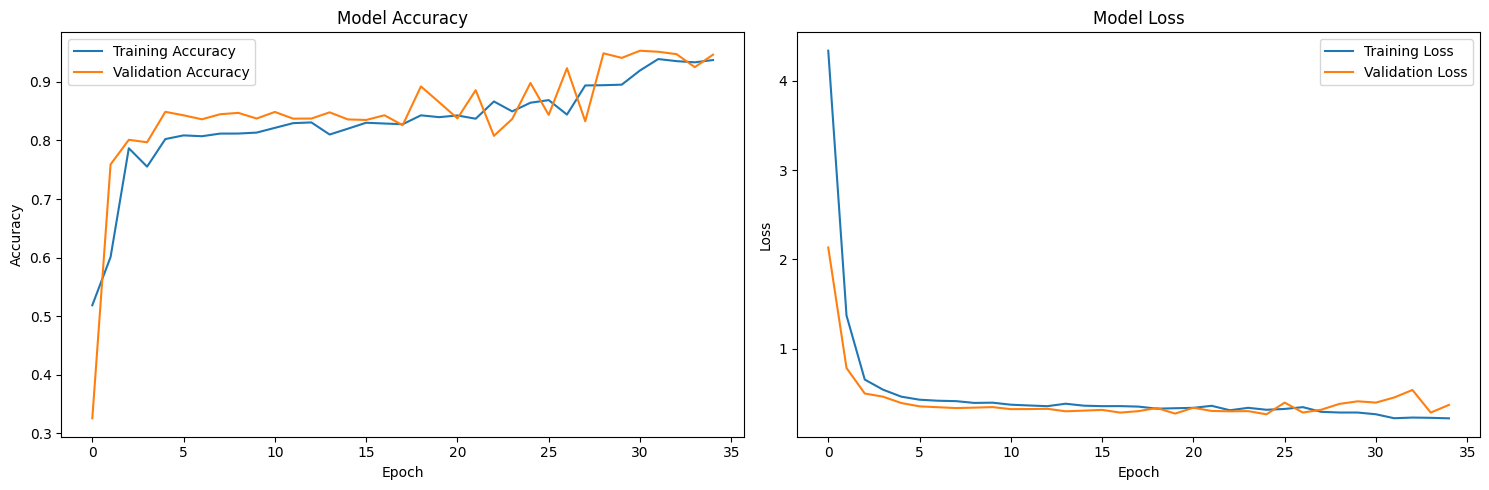

In [15]:
# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


F1 Score: 0.6693


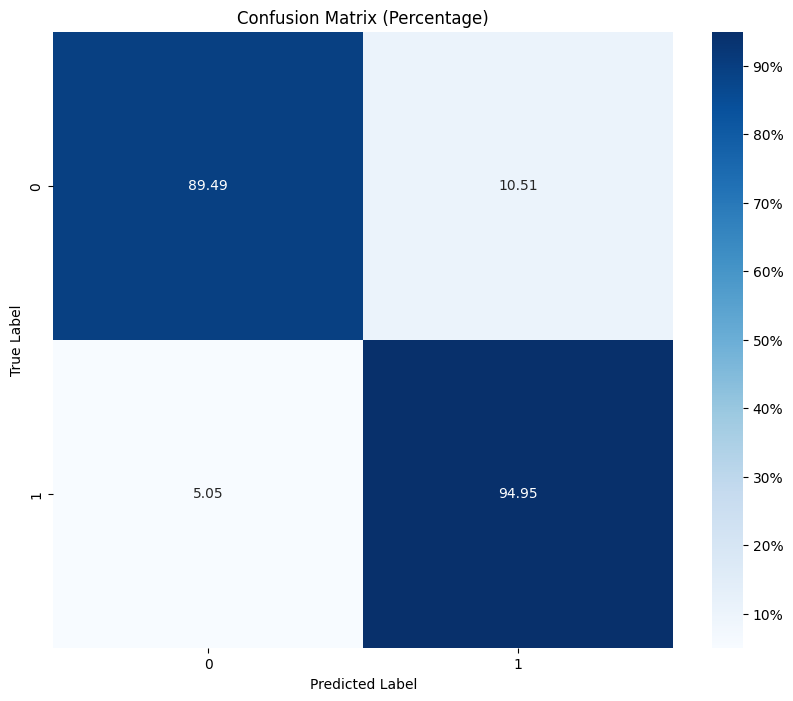

EER: 0.0881
t-DCF: 0.0881


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# EER and t-DCF related imports
from scipy.interpolate import interp1d

# Define t-DCF parameters (these should be set according to your task)
p_target = 0.05  # Prior probability of target speaker
c_miss = 1       # Cost of a miss (false negative)
c_false_alarm = 1 # Cost of a false alarm (false positive)

# Reset the generator to its initial state
eval_gen = data_generator(eval_data_path, batch_size=batch_size)

# Generate predictions and collect true labels
y_pred = []
y_true = []
for _ in range(eval_steps):
    batch_x, batch_y, _ = next(eval_gen)
    batch_pred = model.predict(batch_x, verbose=0)
    y_pred.extend(batch_pred.flatten())
    y_true.extend(batch_y)

# Convert to numpy arrays and ensure same length
y_pred = np.array(y_pred)
y_true = np.array(y_true)
min_len = min(len(y_pred), len(y_true))
y_pred = y_pred[:min_len]
y_true = y_true[:min_len]

# Convert predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)


# Calculate F1 Score
f1 = f1_score(y_true, y_pred_binary)
print(f"F1 Score: {f1:.4f}")


# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Convert confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualize confusion matrix as percentages
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%'})
plt.title('Confusion Matrix (Percentage)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


#---------------------------------------------------------------
# EER Calculation
#---------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
# Find the EER threshold
eer_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]

# Calculate EER
eer = fpr[np.argmin(np.abs(fpr - (1-tpr)))]

print(f"EER: {eer:.4f}")

#---------------------------------------------------------------
# t-DCF Calculation
#---------------------------------------------------------------
def calculate_t_dcf(y_true, y_pred, p_target, c_miss, c_false_alarm, threshold):
    """
    Calculates the tuned Detection Cost Function (t-DCF).
    """
    # Apply threshold to get binary predictions
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Calculate confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

    # Calculate False Alarm Rate (FAR) and Miss Rate (FR)
    far = fp / (tn + fp)
    fr = fn / (tp + fn)

    # Calculate t-DCF
    t_dcf = c_miss * p_target * fr + c_false_alarm * (1 - p_target) * far

    return t_dcf

# Calculate t-DCF using the EER threshold
t_dcf = calculate_t_dcf(y_true, y_pred, p_target, c_miss, c_false_alarm, eer_threshold)
print(f"t-DCF: {t_dcf:.4f}")


In [18]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import noisereduce as nr
from scipy.signal import butter, sosfilt
import soundfile as sf

def denoise_and_amplify(audio, sr):
    try:
        # Noise Reduction
        reduced_noise = nr.reduce_noise(y=audio, sr=sr, stationary=False)
        return reduced_noise
    except Exception as e:
        print(f"Error in denoise_and_amplify: {e}")
        return audio  # Return original audio if an error occurs

def preprocess_and_visualize(file_path, sr=16000, duration=4):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sr, duration=duration)
    
    # Save original audio
    sf.write('original_audio.wav', audio, sr)
    
    # Original Mel Spectrogram
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80, n_fft=2048, hop_length=512)
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.title('Original Mel Spectrogram')
    
    # Noise Reduction using denoise_and_amplify function
    reduced_noise = denoise_and_amplify(audio, sr)
    sf.write('noise_reduced_audio.wav', reduced_noise, sr)
    
    # Final Mel Spectrogram
    plt.subplot(1, 3, 3)
    final_mel_spec = librosa.feature.melspectrogram(y=reduced_noise, sr=sr, n_mels=80, n_fft=2048, hop_length=512)
    librosa.display.specshow(librosa.power_to_db(final_mel_spec, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.title('Final Mel Spectrogram')
    
    plt.tight_layout()
    plt.savefig('mel_spectrograms.png')
    plt.close()

# Use the function
file_path = 'A_2582_0_A.wav'
preprocess_and_visualize(file_path)


In [19]:
# Add this code after your model has been trained and evaluated

# Define the path and filename for the saved model
model_save_path = 'Bi_GRU_RNN.h5'

# Save the model
print(f"\nSaving model to {model_save_path}...")
model.save(model_save_path)
print("Model saved successfully.")


Saving model to Bi_GRU_RNN.h5...
Model saved successfully.



--- Comprehensive Evaluation Metrics ---
Generating predictions for evaluation set...
Processed 62592/62592 samples...
Finished generating predictions. Total samples evaluated: 62592
Using 62592 samples for metric calculation.

Accuracy (Threshold=0.5): 0.9013 (90.13%)
  > Percentage of predictions the model got right overall (Real or Fake).
AUC (Area Under ROC Curve): 0.9701
  > How well the model can distinguish between Real and Fake samples across all thresholds (higher is better).
F1 Score (Threshold=0.5): 0.6725
  > Balances precision and recall, good for uneven datasets (higher is better).

Confusion Matrix (Threshold=0.5):
[[50070  5885]
 [  294  6343]]
  > Shows counts of True Negatives (Top-Left), False Positives (Top-Right),
    False Negatives (Bottom-Left), True Positives (Bottom-Right). (Labels: 0=Fake, 1=Real)


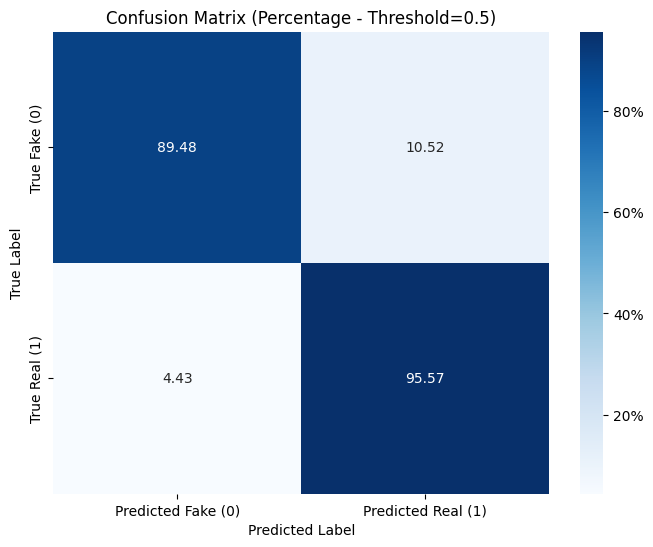

  > Visualization showing percentage of each true class predicted correctly/incorrectly.

EER (Equal Error Rate): 0.0848 (8.48%)
  > EER Threshold: 0.6820
  > Error rate where False Acceptance Rate equals False Rejection Rate (lower is better).
t-DCF @ EER point (approx): 0.0848

Minimum t-DCF: 0.0408
  > Min t-DCF Threshold: 0.9503
  > Average cost of errors using defined costs and priors (P_target=0.05, C_miss=1, C_fa=1) (lower is better).
--- End of Evaluation ---


In [21]:
# Add this cell after model training and potentially after the initial evaluation cell

import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# --- Configuration for t-DCF ---
# These values should reflect the specific scenario/challenge requirements
p_target = 0.05  # Prior probability of the target class (Real/Bona fide)
c_miss = 1       # Cost of missing a target (False Negative - classifying Real as Fake)
c_false_alarm = 1 # Cost of a false alarm (False Positive - classifying Fake as Real)
# --------------------------------

print("\n--- Comprehensive Evaluation Metrics ---")

# --- 1. Generate Predictions and True Labels ---
# Ensure the generator starts from the beginning for a full evaluation
eval_gen_metrics = data_generator(eval_data_path, batch_size=batch_size, shuffle=False) # Use shuffle=False for consistent evaluation order

print("Generating predictions for evaluation set...")
y_pred_scores = []
y_true_labels = []
num_samples_processed = 0
total_eval_samples = eval_samples_count # Get total count from previous cell

# Iterate through the generator to get predictions for the entire evaluation set
for i in range(eval_steps):
    batch_x, batch_y, _ = next(eval_gen_metrics)
    if batch_x.size == 0: # handle potential empty batch at the end
        continue
    batch_pred = model.predict(batch_x, verbose=0)
    y_pred_scores.extend(batch_pred.flatten())
    y_true_labels.extend(batch_y)
    num_samples_processed += len(batch_y)
    print(f"Processed {num_samples_processed}/{eval_steps * batch_size} samples...", end='\r')

print(f"\nFinished generating predictions. Total samples evaluated: {num_samples_processed}")

# Convert to numpy arrays
y_pred_scores = np.array(y_pred_scores)
y_true_labels = np.array(y_true_labels)

# Ensure arrays are not empty and lengths match (should match if loop is correct)
if len(y_pred_scores) == 0 or len(y_true_labels) == 0:
    print("Error: No predictions or labels generated. Cannot calculate metrics.")
else:
    min_len = min(len(y_pred_scores), len(y_true_labels))
    y_pred_scores = y_pred_scores[:min_len]
    y_true_labels = y_true_labels[:min_len]
    print(f"Using {min_len} samples for metric calculation.")

    # --- 2. Calculate Basic Metrics (Threshold = 0.5) ---
    threshold = 0.5
    y_pred_binary = (y_pred_scores >= threshold).astype(int)

    # Accuracy
    accuracy = accuracy_score(y_true_labels, y_pred_binary)
    print(f"\nAccuracy (Threshold=0.5): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("  > Percentage of predictions the model got right overall (Real or Fake).")

    # AUC
    auc = roc_auc_score(y_true_labels, y_pred_scores)
    print(f"AUC (Area Under ROC Curve): {auc:.4f}")
    print("  > How well the model can distinguish between Real and Fake samples across all thresholds (higher is better).")

    # F1 Score
    f1 = f1_score(y_true_labels, y_pred_binary)
    print(f"F1 Score (Threshold=0.5): {f1:.4f}")
    print("  > Balances precision and recall, good for uneven datasets (higher is better).")

    # --- 3. Confusion Matrix ---
    cm = confusion_matrix(y_true_labels, y_pred_binary)
    # Calculate percentages for better interpretation
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'): # Handle potential division by zero if a class has 0 samples
        cm_perc = cm / cm_sum.astype(float) * 100

    print("\nConfusion Matrix (Threshold=0.5):")
    print(cm)
    print("  > Shows counts of True Negatives (Top-Left), False Positives (Top-Right),")
    print("    False Negatives (Bottom-Left), True Positives (Bottom-Right). (Labels: 0=Fake, 1=Real)")

    # Visualize Confusion Matrix (Percentages)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_perc, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Predicted Fake (0)', 'Predicted Real (1)'],
                yticklabels=['True Fake (0)', 'True Real (1)'],
                cbar_kws={'format': '%.0f%%'})
    plt.title('Confusion Matrix (Percentage - Threshold=0.5)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("  > Visualization showing percentage of each true class predicted correctly/incorrectly.")


    # --- 4. EER (Equal Error Rate) ---
    fpr, tpr, thresholds_roc = roc_curve(y_true_labels, y_pred_scores, pos_label=1)
    fnr = 1 - tpr # False Negative Rate

    # Calculate the index where FNR is closest to FPR (for fallback and t-DCF@EER)
    # Ensure fpr and fnr are not empty before proceeding
    if len(fpr) > 0 and len(fnr) > 0:
        eer_index = np.nanargmin(np.abs(fnr - fpr))
        eer_threshold_approx = thresholds_roc[eer_index]
        eer_approx = (fpr[eer_index] + fnr[eer_index]) / 2 # Approximate EER value

        # Try to find the EER using interpolation for better precision
        try:
            # Ensure fpr is sorted for interp1d (it usually is from roc_curve, but good practice)
            # Also handle cases where fpr values might not be unique or monotonically increasing
            unique_fpr, unique_indices = np.unique(fpr, return_index=True)
            unique_tpr = tpr[unique_indices]

            # Check if we have enough points for interpolation
            if len(unique_fpr) > 1:
                 # Interpolate tpr as a function of fpr
                interp_tpr = interp1d(unique_fpr, unique_tpr, fill_value="extrapolate")
                # Find the EER point where fpr = 1 - tpr <=> tpr = 1 - fpr
                eer = brentq(lambda x: 1. - x - interp_tpr(x), 0., 1.)

                # Interpolate the threshold corresponding to the EER's FPR value
                # Need thresholds corresponding to unique_fpr for accurate threshold interpolation
                unique_thresholds = thresholds_roc[unique_indices]
                 # Reverse arrays if thresholds are decreasing (as is typical from roc_curve)
                if unique_thresholds[0] > unique_thresholds[-1]:
                    eer_threshold = interp1d(unique_fpr[::-1], unique_thresholds[::-1])(eer)
                else:
                    eer_threshold = interp1d(unique_fpr, unique_thresholds)(eer)

                print(f"\nEER (Equal Error Rate): {eer:.4f} ({eer*100:.2f}%)")
                print(f"  > EER Threshold: {eer_threshold:.4f}")
                print("  > Error rate where False Acceptance Rate equals False Rejection Rate (lower is better).")
            else:
                 raise ValueError("Not enough unique points for interpolation")

        except (ValueError, Exception) as e:
            # Fallback if interpolation fails
            eer = eer_approx
            eer_threshold = eer_threshold_approx
            print(f"\nEER (Equal Error Rate - approx): {eer:.4f} ({eer*100:.2f}%)")
            print(f"  > EER Threshold (approx): {eer_threshold:.4f}")
            print("  > Error rate where False Acceptance Rate equals False Rejection Rate (lower is better).")
            print(f"  > (Interpolation fallback used due to: {e})")

    else:
        print("\nError: Cannot calculate EER - FPR or FNR array is empty.")
        eer = np.nan
        eer_threshold = np.nan
        eer_index = -1 # Assign a value to prevent NameError, although subsequent calculations might fail


    # --- 5. t-DCF (tuned Detection Cost Function) ---
    def calculate_t_dcf(fpr, fnr, thresholds, p_target, c_miss, c_fa):
        """
        Calculates the minimum t-DCF based on FRR (fnr) and FAR (fpr).
        Note: thresholds should correspond to fpr and fnr.
        """
        if len(fpr) == 0 or len(fnr) == 0:
            return np.inf, np.nan # Cannot calculate if roc_curve failed

        dcf = c_miss * fnr * p_target + c_fa * fpr * (1 - p_target)

        # Check if dcf is empty or contains only NaN/Inf
        if dcf.size == 0 or np.all(np.isnan(dcf)) or np.all(np.isinf(dcf)):
             return np.inf, np.nan

        min_dcf_idx = np.nanargmin(dcf) # Use nanargmin to handle potential NaNs
        min_dcf = dcf[min_dcf_idx]
        min_dcf_threshold = thresholds[min_dcf_idx] if min_dcf_idx < len(thresholds) else np.nan
        return min_dcf, min_dcf_threshold

    # Calculate minimum t-DCF across all thresholds
    min_tdcf, min_tdcf_threshold = calculate_t_dcf(fpr, fnr, thresholds_roc, p_target, c_miss, c_false_alarm)

    # Calculate t-DCF specifically at the EER *index* (approximate EER point)
    # Ensure eer_index is valid before trying to access array elements
    if eer_index != -1 and eer_index < len(fpr) and eer_index < len(fnr):
        fpr_at_eer_idx = fpr[eer_index]
        fnr_at_eer_idx = fnr[eer_index]
        tdcf_at_eer_point = c_miss * fnr_at_eer_idx * p_target + c_false_alarm * fpr_at_eer_idx * (1 - p_target)
        print(f"t-DCF @ EER point (approx): {tdcf_at_eer_point:.4f}") # Often reported
    else:
        print("Could not calculate t-DCF @ EER point.")


    print(f"\nMinimum t-DCF: {min_tdcf:.4f}")
    print(f"  > Min t-DCF Threshold: {min_tdcf_threshold:.4f}")
    print(f"  > Average cost of errors using defined costs and priors (P_target={p_target}, C_miss={c_miss}, C_fa={c_false_alarm}) (lower is better).")
    print("--- End of Evaluation ---")